# BIONIC Methods Tests and Data Visualization

## Exploration and Gene Filtering

In [205]:
# imports
from itertools import combinations
import numpy as np
import pandas as pd
import csv
# import pearsonr as pearsonr
# from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [206]:
#File Read
# df = pd.read_csv("../outputs/previous_attemps/locus_tag_processed.csv", sep=',', index_col=0, header=0)
# df

,35D-0H-16C-A,35D-0H-16C-B,35D-2H-16C-A,37D-2H-16C-B,40D-5H-16C-A,40D-5H-16C-B,44D-9H-16C-A,44D-9H-16C-B,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
probe_name,,,,,,,,,,,,,,
AT2G42240,110.0,95.2,91.1,133.4,97.2,121.3,85.2,125.7,92.9,127.4,92.7,102.4,102.5,112.5
AT2G42250,28.5,27.2,34.2,29.3,28.4,30.5,18.5,24.6,26.7,12.0,42.5,35.3,21.9,31.7
AT2G42270,87.8,89.8,72.2,83.4,86.0,85.2,108.0,66.4,91.0,94.6,98.6,76.5,81.6,86.3
AT2G42280,42.5,35.0,21.2,30.5,17.1,14.4,19.8,1.2,41.7,31.1,21.2,17.3,18.2,12.3
AT2G42120,262.4,282.2,248.7,266.0,209.7,235.3,204.1,289.5,228.7,213.9,248.7,275.3,233.3,246.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257585_at,4.0,6.4,5.8,9.2,1.8,1.9,17.7,2.8,8.3,2.0,4.0,10.6,5.5,1.8
AT1G50760,3.9,8.8,13.0,6.1,13.8,31.0,12.8,0.5,9.4,22.8,14.7,5.5,27.7,1.5
AT1G56310,153.5,148.0,78.4,112.0,97.2,114.7,109.8,112.8,93.4,105.7,101.7,91.2,89.2,81.6


In [207]:
# df.index.isna().sum()

0

### Pre-processes the probe names
Pre-processed the gene expression data, separating the probe names and removing the probes from organs (ATC and ATM).

In [208]:
# with open('../outputs/previous_attemps/locus_tag_processed.csv', 'r') as file:
#     reader = csv.reader(file)
#     header = next(reader)
#     new_rows = []
#
#     for row in reader:
#         probe_names = [row[0][i:i+9] for i in range(0, len(row[0]), 9)]
#
#         # Filter out probes from organs (ATC and ATM)
#         probe_names = [probe for probe in probe_names if not probe.startswith('ATC') and not probe.startswith('ATM')]
#
#         # Remove ATM and ATC from the list of probe names if they are aliases
#         for i in range(len(probe_names)):
#             if probe_names[i] == 'ATC' or probe_names[i] == 'ATM':
#                 probe_names.pop(i)
#
#         if len(probe_names) > 0:
#             new_row = [';'.join(probe_names)] + row[1:]
#             new_rows.append(new_row)
#
# with open('../outputs/probes_alias_sep.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(header)
#     writer.writerows(new_rows)

In [214]:
#File Read
# df = pd.read_csv("../outputs/current_df/probes_alias_sep.csv", sep=',', index_col=0, header=0)
# df.index.isna().sum()

0

###  Map probe names to gene symbols
Map the probe names to gene symbols.

In [211]:
# def map_probes_to_genes(input_file, mapping_file):
#     # Read the mapping file and create a dictionary mapping probe names to gene symbols
#     probe_to_gene = {}
#     with open(mapping_file, 'r') as map_file:
#         for line in map_file:
#             probe, gene = line.strip().split()
#             probe_to_gene[probe] = gene
#
#     # Read in the input file as a DataFrame
#     input_df = pd.read_csv(input_file)
#
#     # Map the gene symbols for each probe name
#     gene_symbols = []
#     for probe_name in input_df['probe_name']:
#         sub_probes = probe_name.split(';')
#         gene_symbol = ''
#         if len(sub_probes) > 1:
#             gene_symbol += ';'.join([probe_to_gene.get(sub_probe, sub_probe) for sub_probe in sub_probes])
#         else:
#             gene_symbol += probe_to_gene.get(sub_probes[0], sub_probes[0])
#         gene_symbols.append(gene_symbol)
#
#     # Replace the "probe_name" column with "gene_symbol"
#     input_df['gene_symbol'] = gene_symbols
#     input_df = input_df.drop(columns=['probe_name'])
#     input_df = input_df.set_index('gene_symbol')
#
#     # Write the output file
#     input_df.to_csv('../outputs/current_df/genesymb_processed.csv')
#
# map_probes_to_genes('../outputs/probes_alias_sep.csv', '../gene_mapping/gene_symbol_mapping.txt')

In [213]:
#File Read
# df = pd.read_csv("../outputs/current_df/genesymb_processed.csv", sep=',', index_col=0, header=0)
# df.index.isna().sum()

0

## Scaling and Filtering

In [215]:
#File Read
df = pd.read_csv("../outputs/current_df/genesymb_processed.csv", sep=',', index_col=0, header=0)
df

,35D-0H-16C-A,35D-0H-16C-B,35D-2H-16C-A,37D-2H-16C-B,40D-5H-16C-A,40D-5H-16C-B,44D-9H-16C-A,44D-9H-16C-B,37D-2H-25C-A,37D-2H-25C-B,40D-5H-25C-A,40D-5H-25C-B,44D-9H-25C-A,44D-9H-25C-B
gene_symbol,,,,,,,,,,,,,,
AT2G42240,110.0,95.2,91.1,133.4,97.2,121.3,85.2,125.7,92.9,127.4,92.7,102.4,102.5,112.5
AT2G42250,28.5,27.2,34.2,29.3,28.4,30.5,18.5,24.6,26.7,12.0,42.5,35.3,21.9,31.7
AT2G42270,87.8,89.8,72.2,83.4,86.0,85.2,108.0,66.4,91.0,94.6,98.6,76.5,81.6,86.3
AT2G42280,42.5,35.0,21.2,30.5,17.1,14.4,19.8,1.2,41.7,31.1,21.2,17.3,18.2,12.3
AT2G42120,262.4,282.2,248.7,266.0,209.7,235.3,204.1,289.5,228.7,213.9,248.7,275.3,233.3,246.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257585_at,4.0,6.4,5.8,9.2,1.8,1.9,17.7,2.8,8.3,2.0,4.0,10.6,5.5,1.8
NLP1,3.9,8.8,13.0,6.1,13.8,31.0,12.8,0.5,9.4,22.8,14.7,5.5,27.7,1.5
TPS10,153.5,148.0,78.4,112.0,97.2,114.7,109.8,112.8,93.4,105.7,101.7,91.2,89.2,81.6


In [216]:
# Check the value ranges of the expression values for each conditions
grouped_data = df.groupby(df.columns, axis=1)
grouped_data.describe()

,,count,mean,std,min,25%,50%,75%,max
35D-0H-16C-A,35D-0H-16C-A,22429.0,272.141892,689.540573,0.0,17.8,78.0,248.8,11717.7
35D-0H-16C-B,35D-0H-16C-B,22429.0,262.220523,621.614470,0.0,15.7,80.8,253.6,9982.1
35D-2H-16C-A,35D-2H-16C-A,22429.0,270.547340,673.979040,0.0,20.1,82.6,251.1,11184.2
37D-2H-16C-B,37D-2H-16C-B,22429.0,264.255401,638.450487,0.0,16.1,82.4,250.6,9832.8
37D-2H-25C-A,37D-2H-25C-A,22429.0,266.858001,650.341099,0.0,20.2,87.2,254.1,11547.8
37D-2H-25C-B,37D-2H-25C-B,22429.0,265.292064,649.280440,0.1,16.6,85.7,254.0,10688.8
40D-5H-16C-A,40D-5H-16C-A,22429.0,267.300526,649.978332,0.0,15.9,80.7,254.4,10244.4
40D-5H-16C-B,40D-5H-16C-B,22429.0,266.866040,659.104229,0.0,19.7,83.9,248.7,10996.7
40D-5H-25C-A,40D-5H-25C-A,22429.0,266.394289,644.875845,0.1,20.5,87.4,256.6,11045.5
40D-5H-25C-B,40D-5H-25C-B,22429.0,266.249770,660.387459,0.2,18.2,84.8,253.6,11509.6


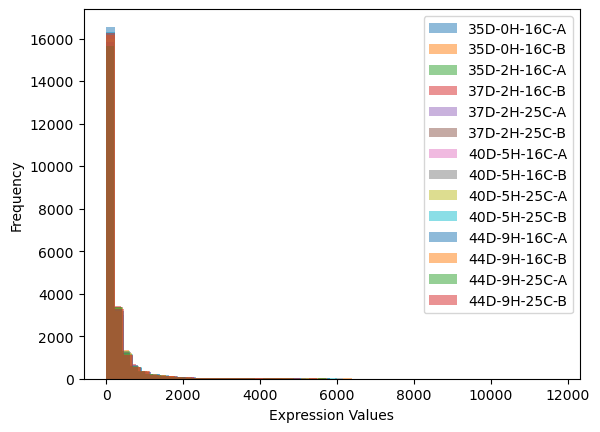

In [217]:
# Plot distribution of expression values for each condition

for sample, group in grouped_data:
    plt.hist(group[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.legend()

plt.show()

### Separate datasets by conditions

In [218]:
# Separate dataset by temperatures
sixteen_df = df.iloc[:, :8]
sixteen_df.to_csv("../outputs/sixteen_df.csv")
twenty_five_df = df.iloc[:, 8:16]
twenty_five_df.to_csv("../outputs/twenty_five_df.csv")

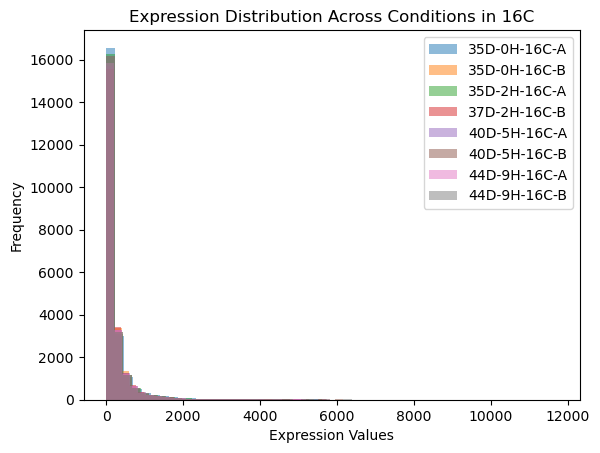

In [221]:
# Expression distribution across conditions in 16C
grouped_sixteen = sixteen_df.groupby(sixteen_df.columns, axis=1)

for sample, condition in grouped_sixteen:
    plt.hist(condition[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.title("Expression Distribution Across Conditions in 16C")
plt.legend()

plt.show()

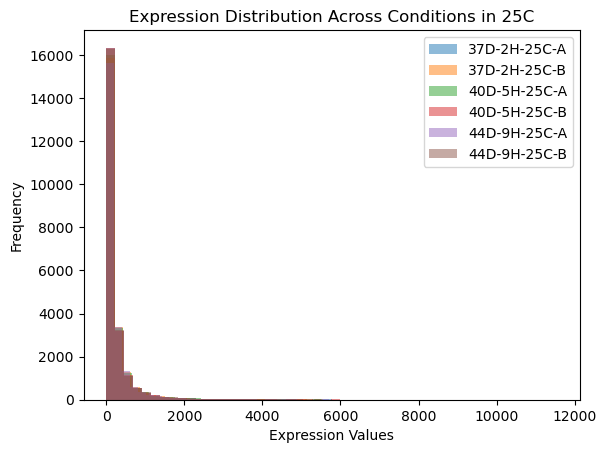

In [222]:
# Expression distribution across conditions in 25C
grouped_twenty_five = twenty_five_df.groupby(twenty_five_df.columns, axis=1)

for sample, condition in grouped_twenty_five:
    plt.hist(condition[sample], bins=50, alpha=0.5, label=sample)

plt.xlabel("Expression Values")
plt.ylabel("Frequency")
plt.title("Expression Distribution Across Conditions in 25C")
plt.legend()

plt.show()

### Filter by Coefficient of Variation

In [223]:
# Calculate CoV for 16C
sixteen_df = pd.read_csv("../outputs/sixteen_df.csv", index_col='gene_symbol')

# Calculate the mean and standard deviation for each gene
sixteen_mean = sixteen_df.mean(axis=1)
sixteen_std = sixteen_df.std(axis=1)

# Calculate the coefficient of variation for each gene
sixteen_cv = (sixteen_std / sixteen_mean) * 100

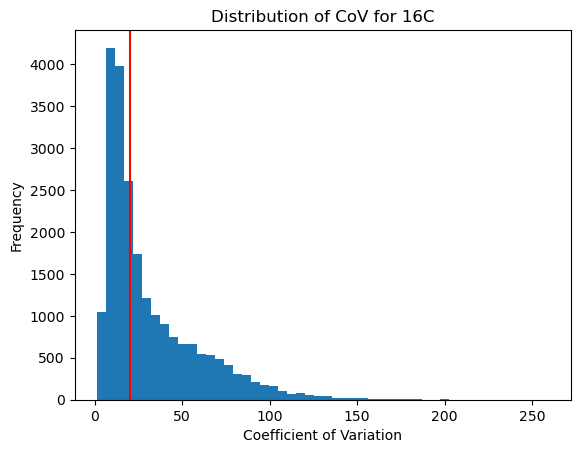

In [224]:
# Visualize CoV
plt.hist(sixteen_cv, bins=50)
plt.xlabel("Coefficient of Variation")
plt.ylabel("Frequency")
plt.title("Distribution of CoV for 16C")
plt.axline((20, 0), (20, 100), color='r')
plt.show()

In [225]:
# Filter out genes with a CV below 25%
threshold = 20
filtered_sixteen_genes = sixteen_cv[sixteen_cv >= threshold].index.tolist()
filtered_sixteen_df = sixteen_df.loc[filtered_sixteen_genes, :]
print(len(filtered_sixteen_genes))

11578


In [227]:
# Calculate CoV for 25C
twenty_five_df = pd.read_csv("../outputs/twenty_five_df.csv", index_col='gene_symbol')

# Calculate the mean and standard deviation for each gene
twenty_five_mean = twenty_five_df.mean(axis=1)
twenty_five_std = twenty_five_df.std(axis=1)

# Calculate the coefficient of variation for each gene
twenty_five_cv = (twenty_five_std / twenty_five_mean) * 100

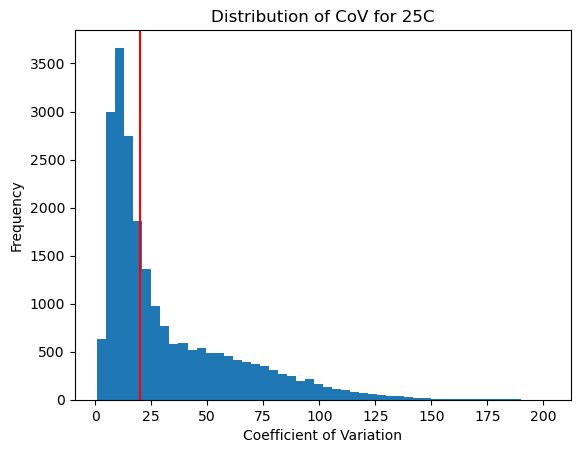

In [228]:
# Visualize CoV
plt.hist(twenty_five_cv, bins=50)
plt.xlabel("Coefficient of Variation")
plt.ylabel("Frequency")
plt.title("Distribution of CoV for 25C")
plt.axline((20, 0), (20, 100), color='r')
plt.show()

In [229]:
# Filter out genes with a CV below 25%
threshold = 20
filtered_cov_twentyfive_genes = twenty_five_cv[twenty_five_cv >= threshold].index.tolist()
filtered_twentyfive_cov_df = twenty_five_df.loc[filtered_cov_twentyfive_genes, :]
print(len(filtered_cov_twentyfive_genes))

10999


### Filter by Mean Absolute Deviation

In [231]:
# Calculate MAD for each gene in 16C

sixteen_mad = np.mean(np.abs(sixteen_df - sixteen_df.mean()), axis=1)
sixteen_median_mad = np.median(sixteen_mad)

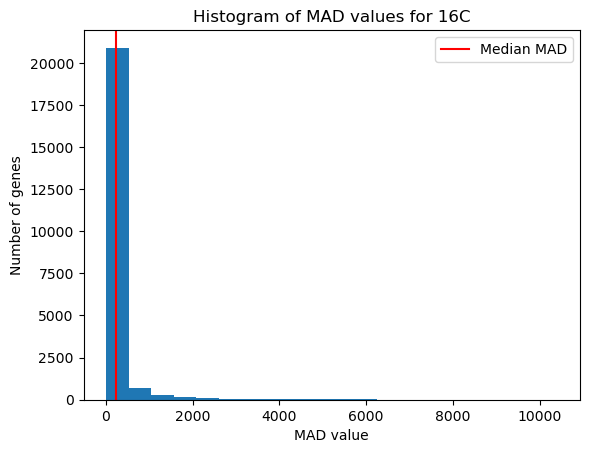

In [232]:
# Visualize MAD values
plt.hist(sixteen_mad, bins=20)
plt.axvline(x=sixteen_median_mad, color='red', linestyle='-', label='Median MAD', )
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 16C')
plt.legend()
plt.show()

In [233]:
# Filter out by the median of the MAD value
threshold = 0.8 * sixteen_median_mad
filtered_sixteen_mad = sixteen_df.loc[sixteen_mad >= threshold, :]
print(len(filtered_sixteen_mad))

14320


In [234]:
# Calculate MAD for each gene in 25C

twenty_five_mad = np.mean(np.abs(twenty_five_df - twenty_five_df.mean()), axis=1)
twenty_five_median_mad = np.median(twenty_five_mad)

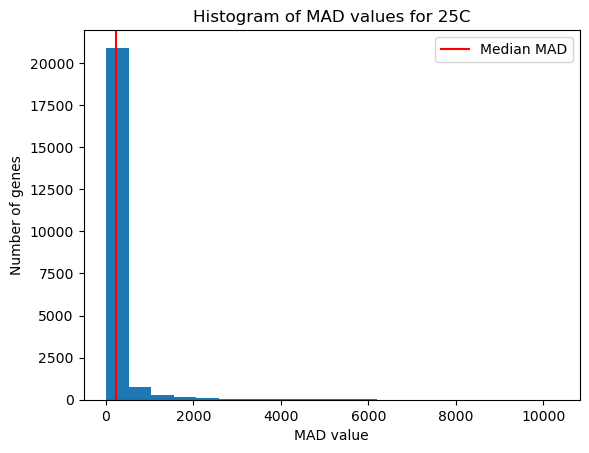

In [235]:
# Visualize MAD values for 25C
plt.hist(twenty_five_mad, bins=20)
plt.axvline(x=twenty_five_median_mad, color='red', linestyle='-', label='Median MAD', )
plt.xlabel('MAD value')
plt.ylabel('Number of genes')
plt.title('Histogram of MAD values for 25C')
plt.legend()
plt.show()

In [236]:
# Filter out by the median of the MAD value
threshold = 0.8 * twenty_five_median_mad
filtered_twenty_five_mad = twenty_five_df.loc[twenty_five_mad >= threshold, :]
print(len(filtered_twenty_five_mad))

14184


## Scale filtered datasets

In [240]:
# Scale values by individual samples
scaler_sixteen_cov = StandardScaler()
scaled_sixteen_cov = scaler_sixteen_cov.fit_transform(filtered_sixteen_df)
scaled_sixteen_cov = pd.DataFrame(scaled_sixteen_cov, columns=filtered_sixteen_df.columns, index=filtered_sixteen_df.index)
scaled_sixteen_cov.to_csv("../outputs/separate_conditions/scaled_sixteen_cov.csv")

In [241]:
scaler_twentyfive_cov = StandardScaler()
scaled_twenty_five_cov = scaler_twentyfive_cov.fit_transform(filtered_twentyfive_cov_df)
scaled_twenty_five_cov = pd.DataFrame(scaled_twenty_five_cov, columns=filtered_twentyfive_cov_df.columns, index=filtered_twentyfive_cov_df.index)
scaled_twenty_five_cov.to_csv("../outputs/separate_conditions/scaled_twenty_five_cov.csv")

In [242]:
scaler_sixteen_mad = StandardScaler()
scaled_sixteen_mad = scaler_sixteen_mad.fit_transform(filtered_sixteen_mad)
scaled_sixteen_mad = pd.DataFrame(scaled_sixteen_mad, columns=filtered_sixteen_mad.columns, index=filtered_sixteen_mad.index)
scaled_sixteen_mad.to_csv("../outputs/separate_conditions/scaled_sixteen_mad.csv")

In [243]:
scaler_twentyfive_mad = StandardScaler()
scaled_twenty_five_mad = scaler_twentyfive_mad.fit_transform(filtered_twenty_five_mad)
scaled_twenty_five_mad = pd.DataFrame(scaled_twenty_five_mad, columns=filtered_twenty_five_mad.columns, index=filtered_twenty_five_mad.index)
scaled_twenty_five_mad.to_csv("../outputs/separate_conditions/scaled_twenty_five_mad.csv")